In [1]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection

In [2]:
data = pandas.read_csv(os.path.join('..', 'data', 'ROI_OrderKey_ROISignal_20220625.csv'))
data.diagnosis.replace({'disease':1, 'normal':0}, inplace=True)
data.head()

,pidn,gender,birthday,Unnamed: 3,Unnamed: 4,case_date,age,diagnosis,etiv,stage I-IIboth,...,PutamenL,PutamenR,PallidumL,PallidumR,HippocampusL,HippocampusR,AmygdalaL,AmygdalaR,AccumbensL,AccumbensR
0,118,1,1959-05-24,NaN,//,2020-05-06,60.994521,1,1718944.373,1.186645,...,1.025486,1.047465,1.144742,1.117940,1.232588,1.322048,1.060368,1.004850,0.927153,0.906127
1,635,0,1947-02-21,NaN,//,2021-09-04,74.586301,1,1509385.466,1.486503,...,1.413219,1.438028,1.164178,1.277366,1.401264,1.513620,1.457985,1.549947,1.604411,1.589300
2,1247,1,1949-07-13,NaN,//,2021-07-23,85.802740,1,1682310.916,0.863529,...,1.034929,0.996200,1.094785,1.121078,0.906051,0.815060,0.866736,0.813185,0.877843,0.933986
3,1274,1,1939-05-19,NaN,//,2021-04-16,78.101370,1,1409945.291,0.917792,...,1.613651,1.602802,1.541347,1.476991,0.863824,0.868055,1.031739,1.030657,1.177117,1.204226
4,1407,1,1935-08-06,NaN,//,2021-04-16,65.753425,1,1381377.973,0.836405,...,1.254035,1.219716,1.246334,1.309690,0.820325,0.841339,0.752240,0.735306,0.645981,0.905331


In [3]:
data.etiv.fillna(data.etiv.median(), inplace=True)

In [4]:
biomarkers = ['Frontal_lobeboth', 'Temporal_lobeboth', 'Occipital_lobeboth', 'Parietal_lobeboth', 'Thalamusboth', 'Caudateboth', 'Putamenboth', 'Pallidumboth', 'Midbrainboth', 'Cerebellum_Crusboth']

0      0.846283
1      0.869107
2      0.868134
3      0.877600
4      0.869405
         ...   
302    0.894141
303    0.883702
304    0.890485
305    0.858177
306    0.885280
Length: 307, dtype: float64
0      0.937755
1      0.966378
2      0.983997
3      0.974565
4      0.952361
         ...   
302    0.975354
303    0.959270
304    0.964314
305    0.950162
306    0.959556
Length: 307, dtype: float64
0      0.981029
1      0.987289
2      0.997705
3      0.988221
4      0.979211
         ...   
302    0.981443
303    0.976883
304    0.976780
305    0.982869
306    0.976356
Length: 307, dtype: float64
0      0.884990
1      0.880838
2      0.877685
3      0.879728
4      0.883327
         ...   
302    0.880246
303    0.882674
304    0.882052
305    0.883270
306    0.882686
Length: 307, dtype: float64
0      1.181278
1      1.190579
2      1.215379
3      1.190744
4      1.171454
         ...   
302    1.170796
303    1.162540
304    1.160673
305    1.182771
306    1.160919
Length: 

<AxesSubplot:xlabel='age', ylabel='Frontal_lobeboth'>

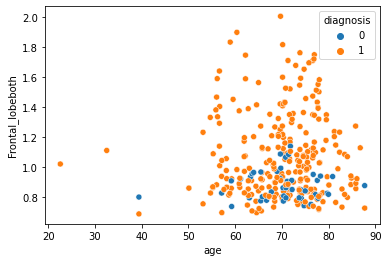

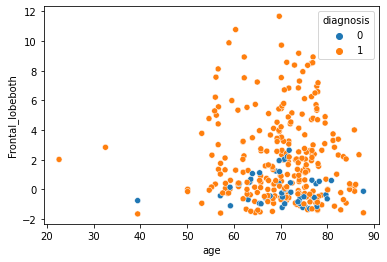

In [5]:
# now we perform the normalization

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(data,copy=True)

# for each biomarker
for biomarker in biomarkers:
    mod = smf.ols('%s ~ age + etiv'%biomarker,  # fit a model finding the effect of age and headsize on biomarker
                  data=data[data.diagnosis==0] # fit this model *only* to individuals in the control group
                 ).fit() # fit model    
    #print(mod.summary())
    
    # get the "predicted" values for all subjects based on the control model parameters
    predicted = mod.predict(data[['age', 'etiv', biomarker]]) 
    print(predicted)
    # calculate our zscore: observed - predicted / SD of the control group residuals
    w_score = (data.loc[:,biomarker] - predicted) / mod.resid.std()
    
    #print(np.mean(w_score[data.Diagnosis==0]))
    #print(np.std(w_score[data.Diagnosis==0]))
    
    # save zscore back into our new (copied) dataframe
    zdata.loc[:,biomarker] = w_score
    
    
plt.figure(0)
sns.scatterplot(x=data.age,y=data.Frontal_lobeboth,hue=data.diagnosis)
plt.figure(1)
sns.scatterplot(x=zdata.age,y=zdata.Frontal_lobeboth,hue=zdata.diagnosis)

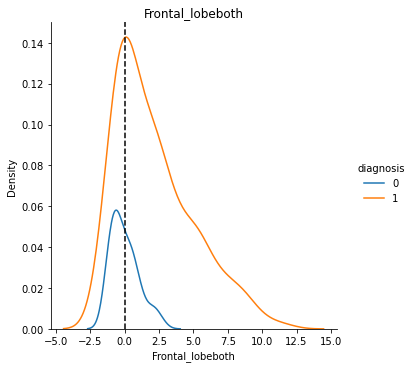

In [6]:
biomarker = biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='diagnosis',kind='kde')
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

In [7]:
N = len(biomarkers)         # number of biomarkers

SuStaInLabels = biomarkers
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

Choosing the settings
The SuStaIn algorithm requires the following inputs.

data
The data you want to run SuStaIn on, of size M subjects by N biomarkers. This needs to be z-scored in the way described in the previous section.

Z_vals
This is the set of z-scores you want to include for each biomarker. The more z-scores you use the longer the SuStaIn algorithm will take to run. Z_vals has size N biomarkers by Z z-scores. If you have more z-scores for some biomarkers than others you can simply leave zeros at the end of biomarker rows with fewer z-scores.

Z_max
The maximum z-score reached at the end of the progression, with size N biomarkers by 1. I'd suggest choosing a value around the 95th percentile of your data but you can experiment with different values. I typically choose an integer for interpretability but you don't have to.

SuStaInLabels
The names of the biomarkers you are using, for plotting purposes.

N_startpoints
The number of startpoints to use when fitting the subtypes hierarchichally. I'd suggest using 25.

N_S_max
The maximum number of subtypes to fit. I'd suggest starting with a lower number - maybe three - and then increasing that if you're getting a significantly better fit with the maximum number of subtypes. You can judge this roughly from the MCMC plot. To properly evaluate the optimal number of subtypes you need to run cross-validation.

N_iterations_MCMC
The number of iterations for the MCMC sampling of the uncertainty in the progression pattern. I'd recommend using 1x10^5 or 1x10^6.

output_folder
Choose an output folder for the results.

dataset_name
Name the results files outputted by SuStaIn.

use_parellel_startpoints
Boolean for whether or not to parallelize the startpoints.

In [8]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 25
N_S_max = 5
N_iterations_MCMC = int(1e5)
output_folder = os.path.join(os.getcwd(), 'KaoOutput')
dataset_name = 'KaoOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              zdata[biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

In [9]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [10]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_subtype2.pickle. Using pickled variables for 2 subtype.
Found pickle file: D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_subtype3.pickle. Using pickled variables for 3 subtype.
Found pickle file: D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_subtype4.pickle. Using pickled variables for 4 subtype.


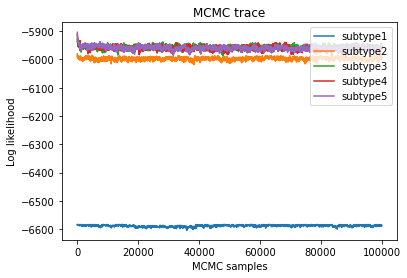

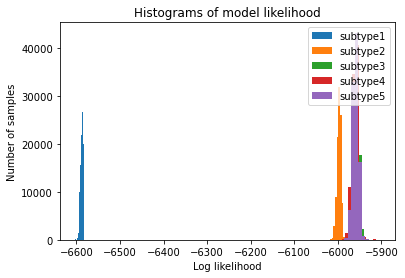

In [11]:
# for each subtype model
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s+1))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s+1))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')


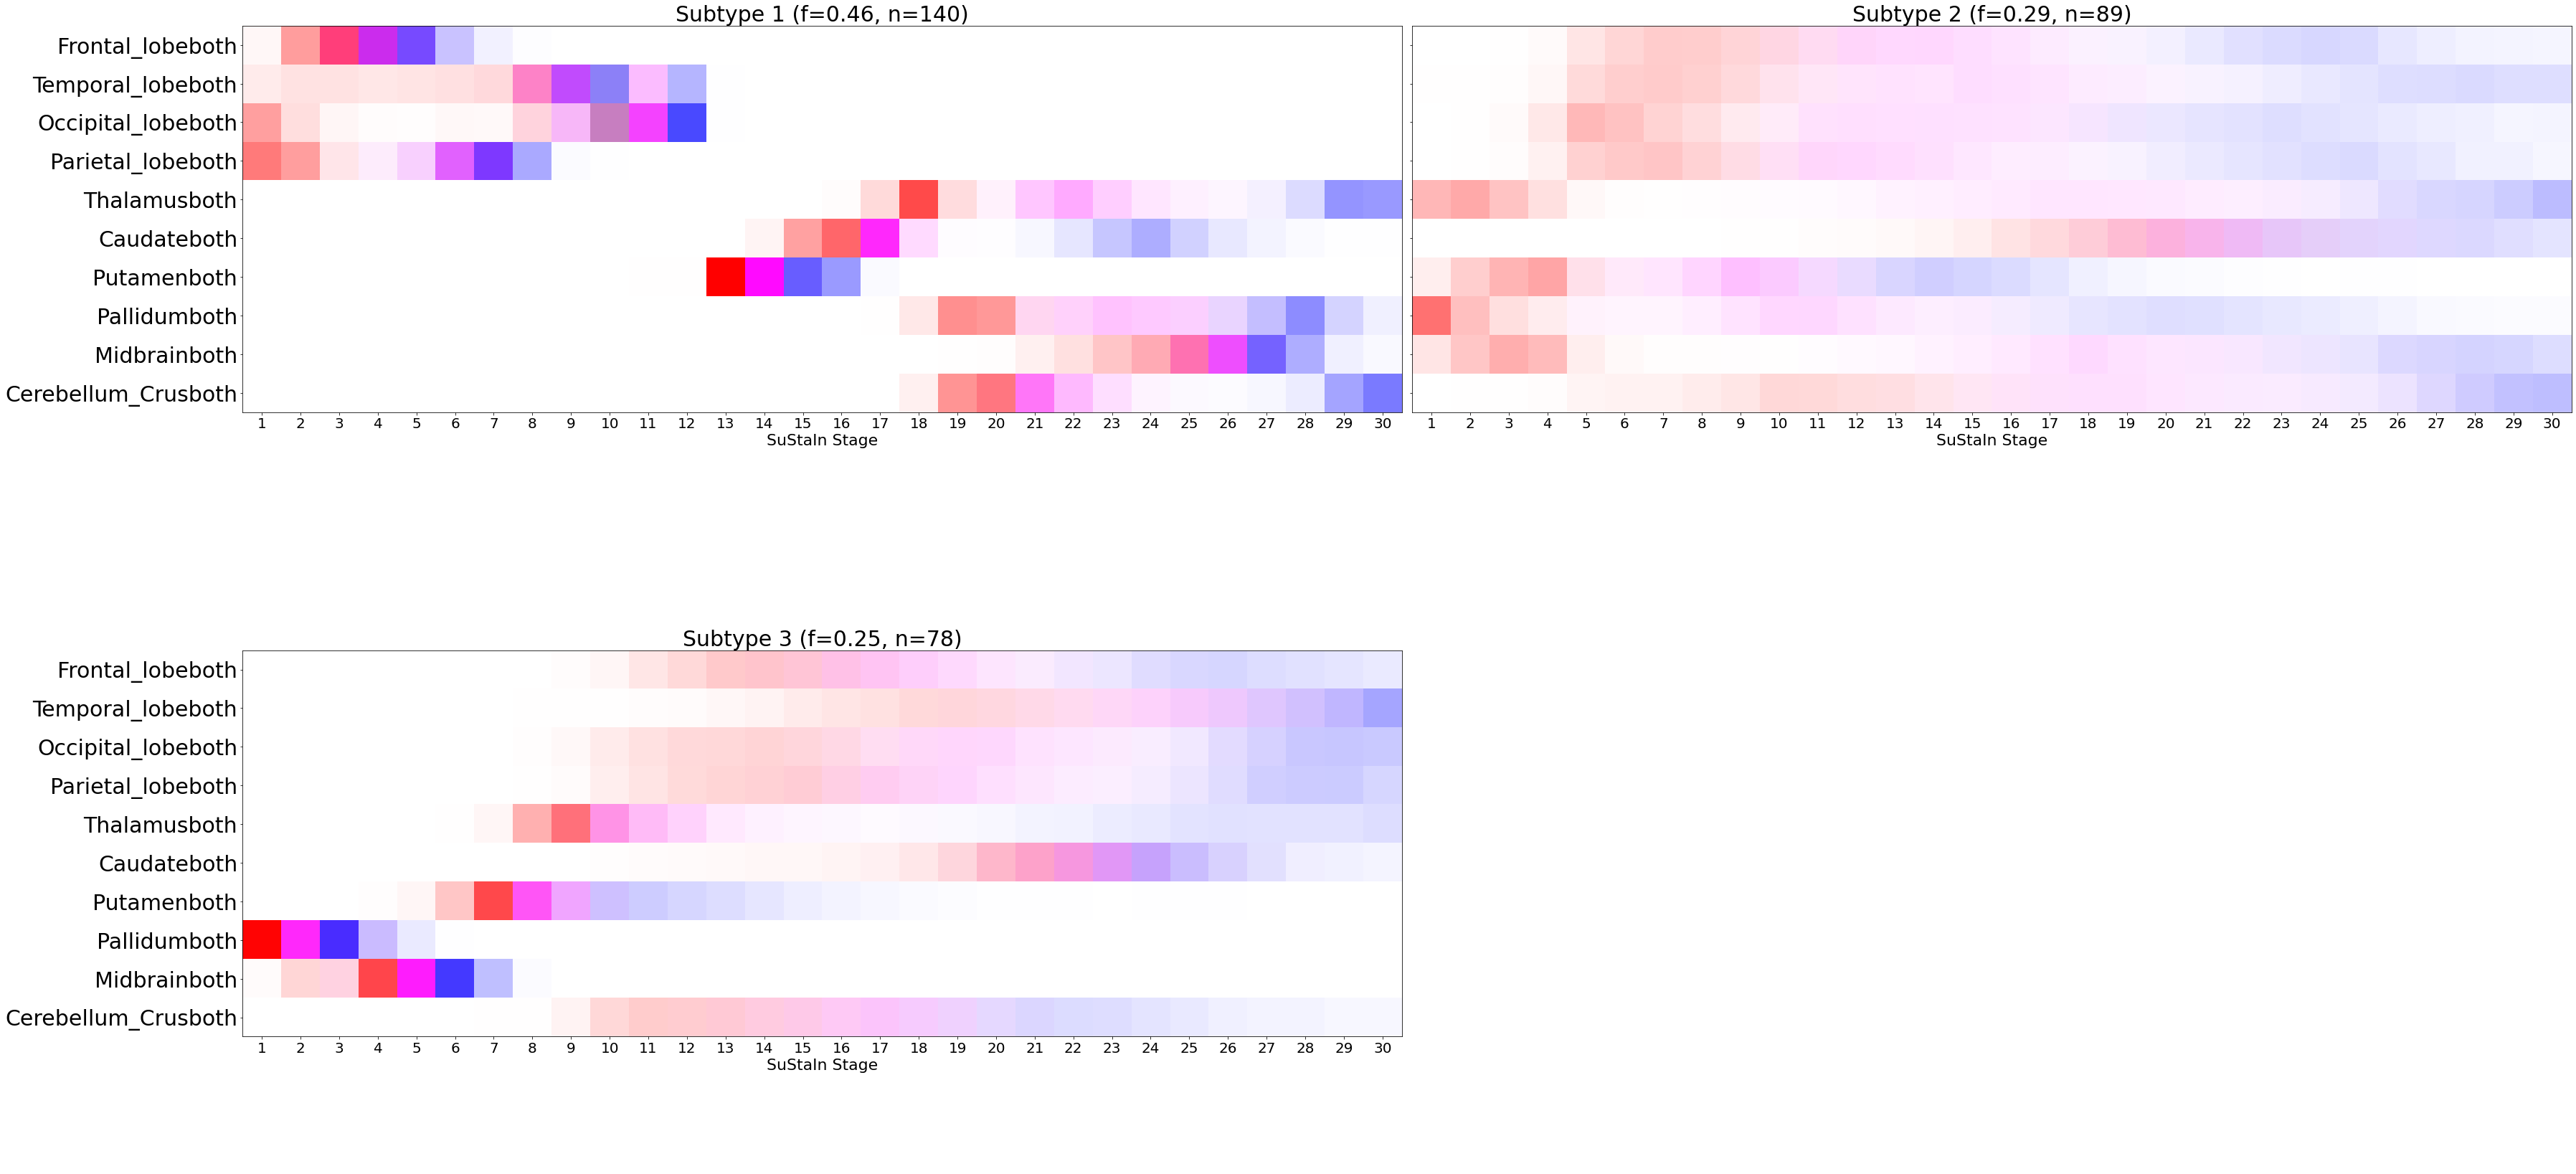

In [18]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 2 # 1 split = 2 subtypes
M = len(zdata) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input,
                                                samples_sequence,
                                                samples_f,
                                                M,
                                                biomarker_labels=biomarkers,
                                                figsize=(50, 25),
                                                title_font_size=30, 
                                                stage_font_size=20,
                                                label_font_size=30)

In [13]:
s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

,pidn,gender,birthday,Unnamed: 3,Unnamed: 4,case_date,age,diagnosis,etiv,stage I-IIboth,...,HippocampusR,AmygdalaL,AmygdalaR,AccumbensL,AccumbensR,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0
0,118,1,1959-05-24,NaN,//,2020-05-06,60.994521,1,1718944.373,1.186645,...,1.322048,1.060368,1.004850,0.927153,0.906127,0.0,0.708631,0.0,0.220518,0.708631
1,635,0,1947-02-21,NaN,//,2021-09-04,74.586301,1,1509385.466,1.486503,...,1.513620,1.457985,1.549947,1.604411,1.589300,0.0,1.000000,17.0,0.250358,1.000000
2,1247,1,1949-07-13,NaN,//,2021-07-23,85.802740,1,1682310.916,0.863529,...,0.815060,0.866736,0.813185,0.877843,0.933986,0.0,0.968787,1.0,0.294881,0.968787
3,1274,1,1939-05-19,NaN,//,2021-04-16,78.101370,1,1409945.291,0.917792,...,0.868055,1.031739,1.030657,1.177117,1.204226,1.0,0.999939,15.0,0.135461,0.000061
4,1407,1,1935-08-06,NaN,//,2021-04-16,65.753425,1,1381377.973,0.836405,...,0.841339,0.752240,0.735306,0.645981,0.905331,1.0,0.557967,1.0,0.201977,0.442033


In [14]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 0
zdata.head()

,pidn,gender,birthday,Unnamed: 3,Unnamed: 4,case_date,age,diagnosis,etiv,stage I-IIboth,...,HippocampusR,AmygdalaL,AmygdalaR,AccumbensL,AccumbensR,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0
0,118,1,1959-05-24,NaN,//,2020-05-06,60.994521,1,1718944.373,1.186645,...,1.322048,1.060368,1.004850,0.927153,0.906127,0.0,0.708631,0.0,0.220518,0.708631
1,635,0,1947-02-21,NaN,//,2021-09-04,74.586301,1,1509385.466,1.486503,...,1.513620,1.457985,1.549947,1.604411,1.589300,1.0,1.000000,17.0,0.250358,1.000000
2,1247,1,1949-07-13,NaN,//,2021-07-23,85.802740,1,1682310.916,0.863529,...,0.815060,0.866736,0.813185,0.877843,0.933986,1.0,0.968787,1.0,0.294881,0.968787
3,1274,1,1939-05-19,NaN,//,2021-04-16,78.101370,1,1409945.291,0.917792,...,0.868055,1.031739,1.030657,1.177117,1.204226,2.0,0.999939,15.0,0.135461,0.000061
4,1407,1,1935-08-06,NaN,//,2021-04-16,65.753425,1,1381377.973,0.836405,...,0.841339,0.752240,0.735306,0.645981,0.905331,2.0,0.557967,1.0,0.201977,0.442033


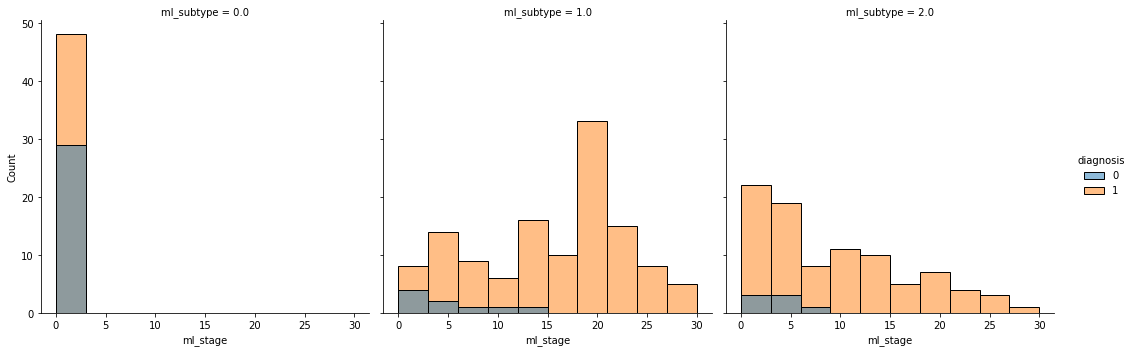

In [15]:
sns.displot(x='ml_stage',hue='diagnosis',data=zdata,col='ml_subtype')

In [16]:
# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds = 3

# generate stratified cross-validation training and test set splits
labels = zdata.diagnosis.values
cv = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, shuffle=True)
cv_it = cv.split(zdata, labels)

# SuStaIn currently accepts ragged arrays, which will raise problems in the future.
# We'll have to update this in the future, but this will have to do for now
test_idxs = []
for train, test in cv_it:
    test_idxs.append(test)
test_idxs = np.array(test_idxs,dtype='object')

In [17]:
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold0_subtype0.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold0_subtype1.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold0_subtype2.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold0_subtype3.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold0_subtype4.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold1_subtype0.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold1_subtype1.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold1_subtype2.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold1_subtype3.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold1_subtype4.pickle
Loading D:\Projects\d2is\pySustain\KaoOutput\pickle_files\KaoOutput_fold2_subtype0.pickle
Loading D: